In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score, auc, log_loss

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

In [4]:
# Define the color palette (17 colors).
Viridis= ['#440154', '#48186a', '#472d7b', '#424086', '#3b528b', '#33638d', '#2c728e', '#26828e', '#21918c', '#1fa088',
          '#28ae80', '#3fbc73', '#5ec962', '#84d44b', '#addc30','#d8e219', '#fde725']  

## Neural Network for Binary Classification

---

Now we'll build a neural net for classification.  
1. Load the data.
2. Make test/train splits. (Should we use cross validation?)
3. Standardize the data.
4. Build the computational graph for the neural network.
5. Train the network using gradient descent a.k.a. back propogation.
6. Evaluate performance 

We read in the dataset from step 5 (feature engineering) which is the same dataset we used for the previous round of modeling.

In [5]:
df = pd.read_csv('../data/dataset5.gz', compression='gzip', header=0, sep=',', quotechar='"')

## Dealing with imbalanced classes

Because our target variable (failure) is highly imbalanced, we need to take several precautions to accurately evaluate our model. Because the data is overwhelmingly positive, a model that predicted "no failure" would be accurate 99% of the time! We will take two steps to deal with imbalance:  
* Up-sample Minority Class
* Use ROC-AUC and F1 as our performance metric rather than accuracy  
https://elitedatascience.com/imbalanced-classes

Because we need to resample, we'll conduct train-test split _before_ separating our X and y data. This is because we only want to oversample the training data, not the testing data! In addition, if we conducted oversampling _before_ the train-test split, we would almost certainly have duplicate data in both the training and testing sets, which would result in severe overfit.

In [6]:
# Split the data
df_train, df_test = train_test_split(df, test_size = .3, random_state=42)

In [7]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_train[df_train['failure']==0]
df_minority = df_train[df_train['failure']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_train_upsampled['failure'].value_counts()


1    65524
0    65524
Name: failure, dtype: int64

In [8]:
# final x-values (features)
X_train=df_train_upsampled.drop(['failure', 'device'], axis=1)
X1_test=df_test.drop(['failure', 'device'], axis=1)

In [9]:
# final y-values
y_train=df_train_upsampled['failure'].values
y1_test=df_test[['device','failure']] # Hold onto the device variable for later use, but remove it from the modeling data.
y_test=df_test['failure'].values

In [10]:
# confirm that lengths match
assert len(X_train)==len(y_train)
assert len(X1_test)==len(y_test)

## Standardization
Machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. It means changing the values so that the standard deviation from the mean equals one. It outputs something very close to a normal distribution.

In [11]:
# Standardize variables

y_train = y_train*-1 + 1
y_test = y_test*-1 + 1

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X1_test)

Our NN consists of input layers, output layers and 1 hidden layer. We are using ReLU as the activation function of the hidden layer and sigmoid for our output layer. We will use `AdamOptimizer` to reduce overfitting during the training of our network.

In [12]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, 
                   shape=(None,X_train.shape[1]),
                   name='X')
y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')

hidden1 = tf.layers.dense(X, units=y_train.shape[1],
                          name='hidden1',
                          activation=tf.nn.relu)
y_hat = tf.layers.dense(hidden1, units=1,
                        name='y_hat',
                        activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

We will train our model for 500 epochs (training steps) with a batch size of 32. That is, at each step, we will train our NN using 32 rows of our data. 

In [13]:
init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(501):
        sess.run(training_op,
                     feed_dict={X:X_train, y:y_train})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        test_err.append(test_loss)
        train_err.append(train_loss)
        if epoch % 10 == 0:
            print('epoch', epoch+1, train_loss, test_loss)
        
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 0.64988536 0.9184532
epoch 11 0.54203236 0.75381196
epoch 21 0.5082868 0.69986755
epoch 31 0.48461288 0.65980846
epoch 41 0.46744797 0.62746644
epoch 51 0.45309135 0.59553564
epoch 61 0.4427814 0.56562907
epoch 71 0.43484125 0.53596306
epoch 81 0.4283889 0.51326364
epoch 91 0.423202 0.49492642
epoch 101 0.41905972 0.47680637
epoch 111 0.41569847 0.46131608
epoch 121 0.4130609 0.44840163
epoch 131 0.41091138 0.43698502
epoch 141 0.40924454 0.42688864
epoch 151 0.40792194 0.41821188
epoch 161 0.4068471 0.41057673
epoch 171 0.40598077 0.4038904
epoch 181 0.4053287 0.3981485
epoch 191 0.40477505 0.39314455
epoch 201 0.40434092 0.38879582
epoch 211 0.40397874 0.38499233
epoch 221 0.4036783 0.38169956
epoch 231 0.40341002 0.37884074
epoch 241 0.40321484 0.37642556
epoch 251 0.40301993 0.3743179
epoch 261 0.40284324 0.37249702
epoch 271 0.4027038 0.37095997
epoch 281 0.40255773 0.3696032
epoch 291 0.40244702 0.36849412
epoch 301 0.40232712 0.36749777
epoch 311 0.4022273 0.36670682
epo

As the model iterates over epochs, model error decreases (this is good). In addition, test error becomes lower than training error (also good). At a certain point, the decrease in error levels out, which tells the model it's time to stop iterating as no additional loss in error is likely to occur with further iterations.

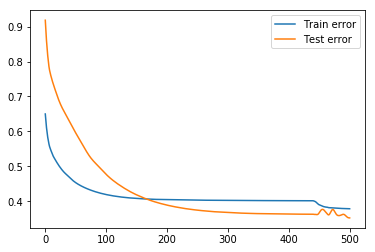

In [14]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.legend()
plt.savefig('nn_error.png')

We set the threshold at 50% - that is, any prediction with probability greater than 50% is predicted as a failure.

In [15]:
predictions = (pred > 0.5).astype(int)
pred[0], y_test[0]

(array([0.810501], dtype=float32), array([1]))

## Model Evaluation

Just as with the previous logistic regression model, we examine our metrics to determine the accuracy and precision of our model.

In [16]:
# Calculate the roc-auc score
auc_tf=metrics.roc_auc_score(y_test, predictions)
acc_tf = metrics.accuracy_score(y_test, predictions)
f1_tf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_tf,4))
print('Accuracy', "%.4f" % round(acc_tf,4))
print('AUC Score', "%.4f" % round(auc_tf,4))

F1 Score 0.9593
Accuracy 0.9218
AUC Score 0.8809


In [17]:
# Log loss. Can we beat random guessing? Lower is better.
guesses=np.full((len(y_test), ), .5)
print(log_loss(y_test, guesses))
print(log_loss(y_test, predictions)) 

0.6931471805599453
2.7018168151541504


In [18]:
# Unpickle the results from previous models (logreg, etc.)
pickle_off = open('model_metrics.pkl','rb')
results = pickle.load(pickle_off)
results['neural net']=[f1_tf, acc_tf, auc_tf]
results

,naive bayes,logistic regression,k-nearest neighbors,random forest,neural net
F1 score,0.004476,0.010887,0.020202,0.000000,0.959263
Accuracy,0.778450,0.890114,0.996549,0.999004,0.921774
AUC score,0.669322,0.785151,0.518700,0.499947,0.880924


In [20]:
# Pickle those results for comparison with tensorflow.
with open('../data/model_metrics7.pkl', 'wb') as f:
    pickle.dump(results, f)
f.close()

In [21]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=results.loc['F1 score'].index,
    y=results.loc['F1 score'],
    name=results.index[0],
    marker=dict(color=Viridis[16])
)
mydata2 = go.Bar(
    x=results.loc['Accuracy'].index,
    y=results.loc['Accuracy'],
    name=results.index[1],
    marker=dict(color=Viridis[10])
)
mydata3 = go.Bar(
    x=results.loc['AUC score'].index,
    y=results.loc['AUC score'],
    name=results.index[2],
    marker=dict(color=Viridis[0])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
pio.write_image(fig, '../images/net_metric.png')
iplot(fig)

The neural net is clearly superior to the other models we tried. Not only does it have a higher ROC-AUC score (86%), but its F1 score (96%) is excellent.  Accuracy is lower, but this is not important given the imbalanced classes of our dataset.

In [22]:
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'f1 score':f1, 'accuracy score': accuracy, 'error rate': error, 'precision score': precision, 'recall score': recall, 'ROC-AUC score': rocauc}

model_metrics(y_test, predictions)

{'ROC-AUC score': 0.8809235918251086,
 'accuracy score': 0.9217743943651951,
 'error rate': 0.07822560563480485,
 'f1 score': 0.959263444545303,
 'precision score': 0.9998455300251013,
 'recall score': 0.9218471836502172}

### ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)

In [23]:
FPR, TPR, _ = roc_curve(y_test, predictions)
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

88.1

In [24]:
# ROC-AUC figure

data = [
    {
      'x':FPR, 
      'y':TPR, 
      'type':'scatter',
      'mode': 'lines',
      'name': 'AUC: '+str(roc_score)
      },
     {'x':[0,1], 
      'y':[0,1], 
      'type':'scatter',
      'mode': 'lines',
      'name': 'Baseline Area: 50.0'}]

layout = go.Layout(
    title = 'Receiver Operating Characteristic - Area Under Curve',
    width=650,
    height=600, 
)
fig = go.Figure(data=data, layout=layout)
pio.write_image(fig, '../images/net_rocauc.png')
iplot(fig)

In [25]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
cm=pd.DataFrame(matrix, columns=['predicted: +', 'predicted: -'], index=['ground truth: +', 'ground truth: -'])
cm=cm.reset_index(drop=False)
cm=cm.rename(columns={'index': f'n = {len(y_test)}'})

In [26]:
import plotly.figure_factory as ff
table = ff.create_table(cm)
iplot(table)

In [54]:
# Pickle the results 
with open('../data/confu_matrix7.pkl', 'wb') as f:
    pickle.dump(cm, f)
f.close()

## How often are we accurate when aggregated to the device level?

In [28]:
y1_test=y1_test.reset_index(drop=True) # for the concat to work correctly, must have a clean index.
X1_test=X1_test.reset_index(drop=True) 

preds_df=pd.DataFrame(predictions, columns=['preds'])
combined_testdf=pd.concat([y1_test, preds_df], axis=1)
combined_testdf=pd.concat([combined_testdf, X1_test], axis=1)

print('y_test: ', len(y1_test))
print('predictions: ', len(preds_df))
print('combined: ', len(combined_testdf))

y_test:  28111
predictions:  28111
combined:  28111


In [29]:
combined_testdf.head()

,device,failure,preds,ndays,attribute2,attribute3,attribute4,att5,att6,attribute7,...,att5_lag03,att5_lag04,att6_lag01,att6_lag02,att6_lag03,att6_lag04,attribute7_lag01,attribute7_lag02,attribute7_lag03,attribute7_lag04
0,S1F0S68M,0,1,82,0,0,0,11.0,221134.0,0,...,11.0,11.0,221134.0,221134.0,221134.0,221134.0,0.0,0.0,0.0,0.0
1,Z1F1R76A,0,1,50,0,0,0,6.0,337980.0,0,...,6.0,6.0,337980.0,337976.0,337976.0,337976.0,0.0,0.0,0.0,0.0
2,W1F16RA7,0,1,238,0,0,0,12.0,220429.0,0,...,12.0,12.0,220429.0,220429.0,220429.0,220429.0,0.0,0.0,0.0,0.0
3,S1F131F6,0,1,150,0,0,0,8.0,233912.0,0,...,8.0,8.0,233912.0,233912.0,233912.0,233912.0,0.0,0.0,0.0,0.0
4,W1F14GTK,0,1,84,0,1,0,18.0,338272.0,0,...,18.0,18.0,338272.0,338271.0,338271.0,338271.0,0.0,0.0,0.0,0.0


In [30]:
aggdf=combined_testdf.groupby('device')[['device', 'failure', 'preds']].mean().reset_index(drop=False)
print(aggdf.shape)
aggdf.head()

(676, 3)


,device,failure,preds
0,S1F01E6Y,0.000000,1.000000
1,S1F01XDJ,0.000000,1.000000
2,S1F023H2,0.166667,0.166667
3,S1F02L38,0.000000,1.000000
4,S1F03YZM,0.012821,0.551282


In [31]:
aggdf['failed']=0
aggdf.loc[aggdf['failure']>0, 'failed']=1
aggdf['failed'].value_counts()

0    651
1     25
Name: failed, dtype: int64

In [32]:
aggdf['pred_failed']=0
aggdf.loc[aggdf['preds']>0, 'pred_failed']=1
aggdf['pred_failed'].value_counts()

1    660
0     16
Name: pred_failed, dtype: int64

In [33]:
# Confusion Matrix (device level)
pd.crosstab(aggdf['failed'], aggdf['pred_failed'],  margins=True)

pred_failed,0,1,All
failed,,,
0,14,637,651
1,2,23,25
All,16,660,676


In [34]:
combined_testdf.to_csv('../data/dataset7.gz', compression='gzip', index=False)
print(df.shape)

(93701, 39)


## For plotly dash app

In [38]:
df=combined_testdf
df.columns

Index(['device', 'failure', 'preds', 'ndays', 'attribute2', 'attribute3',
       'attribute4', 'att5', 'att6', 'attribute7', 'S1F0', 'S1F1', 'W1F0',
       'W1F1', 'Z1F0', 'Z1F1', 'attribute2_lag01', 'attribute2_lag02',
       'attribute2_lag03', 'attribute2_lag04', 'attribute3_lag01',
       'attribute3_lag02', 'attribute3_lag03', 'attribute3_lag04',
       'attribute4_lag01', 'attribute4_lag02', 'attribute4_lag03',
       'attribute4_lag04', 'att5_lag01', 'att5_lag02', 'att5_lag03',
       'att5_lag04', 'att6_lag01', 'att6_lag02', 'att6_lag03', 'att6_lag04',
       'attribute7_lag01', 'attribute7_lag02', 'attribute7_lag03',
       'attribute7_lag04'],
      dtype='object')

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, log_loss
y_test=df['failure'].values
predictions=df['preds']
y_test = y_test*-1 + 1
y_test = y_test.reshape(-1,1)
FPR, TPR, _ = roc_curve(y_test, predictions)
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

88.1

In [50]:
# Pickle the results 
with open('../data/FPR.pkl', 'wb') as f:
    pickle.dump(FPR, f)
f.close()

In [51]:
# Pickle the results 
with open('../data/TPR.pkl', 'wb') as f:
    pickle.dump(TPR, f)
f.close()